In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # Linear SVM Classifier
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    recall_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# project helper
from prepare_data import load_clean_dataframe  # type: ignore


def threshold_for_recall(scores, y_true, recall_target=0.85):
    """Return the highest threshold that still achieves recall ≥ target."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    candidates = [t for r, t in zip(rec[:-1], thr) if r >= recall_target]
    return max(candidates) if candidates else thr.min()


In [37]:
df = load_clean_dataframe(labelled_only=True)

# Feature engineering - same as hybrid model
df["title_len"] = df["title"].str.len()
df["contains_date"] = df["title"].str.contains(r"\b20\d{2}\b", regex=True).astype(int)
# ➜ add more flags / numeric columns here to match the full notebook

df["has_pdf"] = df["pdf_url"].notna() & df["pdf_url"].str.strip().ne("")
df["has_pdf"] = df["has_pdf"].astype(int)

# Define feature columns
text_col = "title"
cat_cols = ["ca", "procedure"]
num_cols = ["has_pdf", "title_len", "contains_date"]

y = df["bid"].astype(int).values
X = df.drop(columns=["bid"])

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Positive class ratio: {y.mean():.3f}")


Dataset shape: (2094, 7)
Class distribution: [1955  139]
Positive class ratio: 0.066


/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [38]:
# Preprocessing pipeline - same as hybrid model
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=40_000,
    strip_accents="unicode",
    lowercase=True,
)

preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf_vectorizer, text_col),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

# Linear SVM instead of Logistic Regression
base_clf = LinearSVC(
    max_iter=2000,  # Increased iterations for convergence
    class_weight="balanced",
    dual=False,  # Recommended when n_samples > n_features
    random_state=42,
)

# Create pipeline and add calibration for probability estimates
pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])
calibrated = CalibratedClassifierCV(pipe, cv=3, method="sigmoid")

print("Pipeline created with Linear SVM + calibration")
print(f"TF-IDF max features: {tfidf_vectorizer.max_features:,}")
print(f"SVM parameters: C=1.0, class_weight='balanced'")


Pipeline created with Linear SVM + calibration
TF-IDF max features: 40,000
SVM parameters: C=1.0, class_weight='balanced'


Running 5-fold stratified cross-validation...
Chosen threshold to hit recall ≥0.85  →  0.061

Cross-validation results:
              precision    recall  f1-score   support

           0      0.987     0.793     0.880      1955
           1      0.228     0.856     0.360       139

    accuracy                          0.798      2094
   macro avg      0.607     0.825     0.620      2094
weighted avg      0.937     0.798     0.845      2094



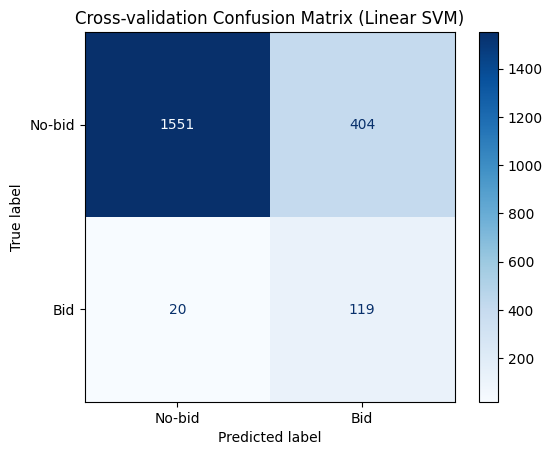

In [39]:
# 5-fold stratified cross-validation
print("Running 5-fold stratified cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(
    calibrated, X, y, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

# Find threshold to hit recall target
thr = threshold_for_recall(proba, y, recall_target=0.85)
print(f"Chosen threshold to hit recall ≥0.85  →  {thr:.3f}")

y_pred = (proba >= thr).astype(int)

print("\nCross-validation results:")
print(classification_report(y, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
plt.title("Cross-validation Confusion Matrix (Linear SVM)")
plt.show()


In [40]:
# Train/test split for more detailed analysis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test set positive class ratio: {y_test.mean():.3f}")

# Fit the model
print("\nFitting calibrated Linear SVM...")
calibrated.fit(X_train, y_train)
print("Model fitted successfully!")


Training set: 1675 samples
Test set: 419 samples
Test set positive class ratio: 0.067

Fitting calibrated Linear SVM...
Model fitted successfully!


Threshold optimization:
Chosen threshold (training) = 0.468
Test set recall = 0.250

Test set classification report:
              precision    recall  f1-score   support

           0      0.949     1.000     0.974       391
           1      1.000     0.250     0.400        28

    accuracy                          0.950       419
   macro avg      0.975     0.625     0.687       419
weighted avg      0.952     0.950     0.936       419



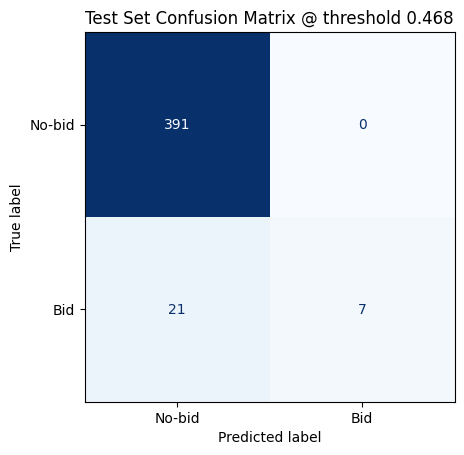

In [41]:
# Threshold optimization on training data, evaluation on test data
print("Threshold optimization:")
print("=" * 50)

# ──────────────────────────────────────────────
# 1️⃣  decide threshold on TRAINING data only
# ──────────────────────────────────────────────
proba_train = calibrated.predict_proba(X_train)[:, 1]
thr = threshold_for_recall(proba_train, y_train, recall_target=0.90)
print(f"Chosen threshold (training) = {thr:0.3f}")

# ──────────────────────────────────────────────
# 2️⃣  evaluate that threshold on TEST set
# ──────────────────────────────────────────────
proba_test = calibrated.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= thr).astype(int)

print(f"Test set recall = {recall_score(y_test, y_pred):.3f}")
print("\nTest set classification report:")
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["No-bid", "Bid"],
    cmap="Blues", colorbar=False
)
plt.title(f"Test Set Confusion Matrix @ threshold {thr:.3f}")
plt.show()


In [42]:
# Detailed threshold analysis - scan all thresholds on TRAINING data
print("Detailed threshold analysis (on training data):")
print("=" * 50)

# Use TRAINING set probabilities for threshold analysis (avoid data leakage)
proba_train = calibrated.predict_proba(X_train)[:, 1]
proba = proba_train

# ------------------------------------------------------------------
# 1.  Scan thresholds and collect FN / FP counts on TRAINING data
# ------------------------------------------------------------------
thresholds = np.linspace(0.0, 1.0, 201)        # 0.00, 0.005, …, 1.00
records = []

for thr in thresholds:
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    records.append(
        {
            "thr": thr,
            "false_neg": fn,
            "false_pos": fp,
            "pred_bid": tp + fp,     # how many rows you must review
            "pred_no_bid": tn + fn,
        }
    )

stats = pd.DataFrame(records)
print(f"Threshold analysis complete. {len(stats)} thresholds analyzed on training data.")


Detailed threshold analysis (on training data):


Threshold analysis complete. 201 thresholds analyzed on training data.


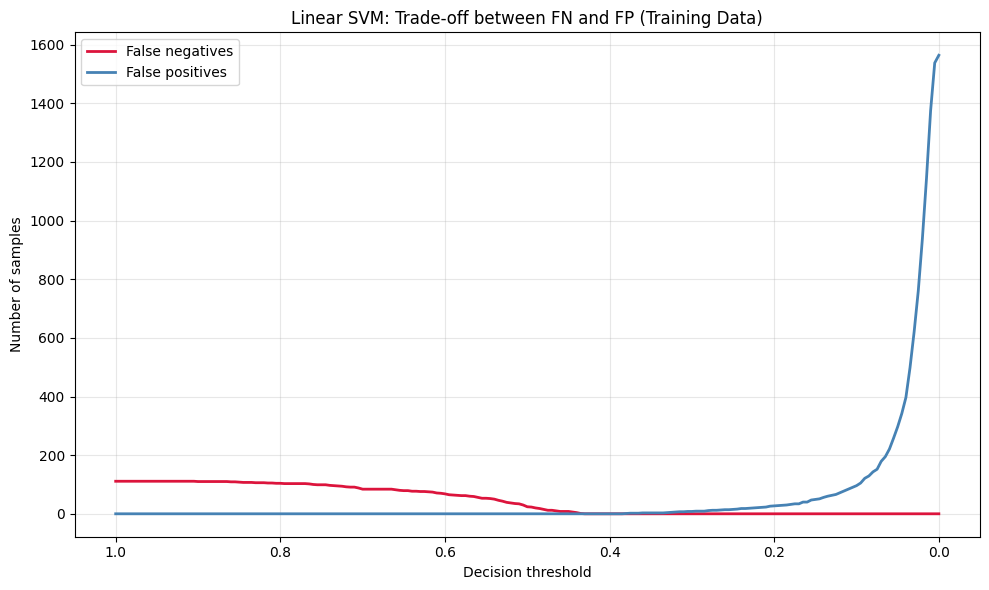

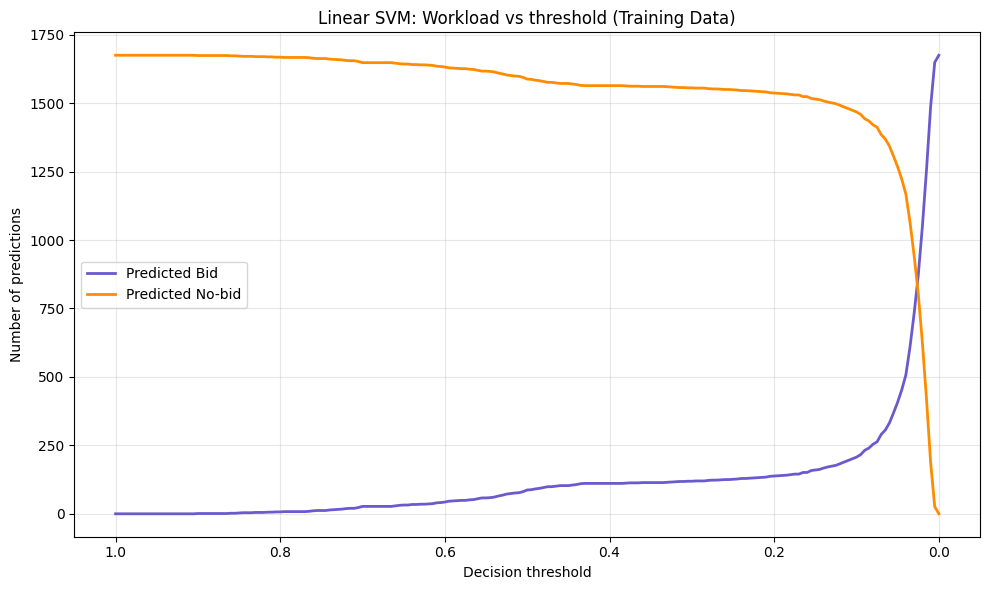

In [43]:
# ------------------------------------------------------------------
# 2.  Plot FN vs FP — makes the trade-off jump out (on training data)
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(data=stats, x="thr", y="false_neg", label="False negatives", color="crimson", linewidth=2)
sns.lineplot(data=stats, x="thr", y="false_pos", label="False positives", color="steelblue", linewidth=2)

plt.gca().invert_xaxis()              # high threshold on the left (optional)
plt.xlabel("Decision threshold")
plt.ylabel("Number of samples")
plt.title("Linear SVM: Trade-off between FN and FP (Training Data)")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3.  (Optional) show how many titles land in each bucket
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(data=stats, x="thr", y="pred_bid",    label="Predicted Bid",    color="slateblue", linewidth=2)
sns.lineplot(data=stats, x="thr", y="pred_no_bid", label="Predicted No-bid", color="darkorange", linewidth=2)

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Number of predictions")
plt.title("Linear SVM: Workload vs threshold (Training Data)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Best threshold (FN ≈ FP) based on training data: 0.385
→ False-negatives (missed bids) : 0
→ False-positives (extra reviews): 0
   Total tenders to review       : 111


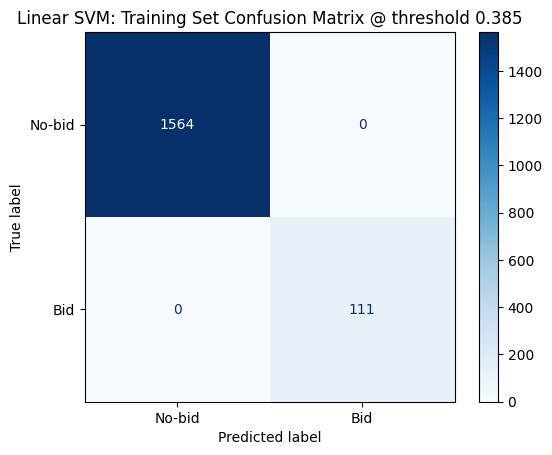

In [44]:
# ------------------------------------------------------------------
# 4.  Pick the threshold where FN ≈ FP  (intersection of the curves)
# ------------------------------------------------------------------
stats["gap"] = (stats["false_neg"] - stats["false_pos"]).abs()
best = stats.loc[stats["gap"].idxmin()]        # smallest distance

thr_opt = best["thr"]
fn_opt  = int(best["false_neg"])
fp_opt  = int(best["false_pos"])

print(f"Best threshold (FN ≈ FP) based on training data: {thr_opt:0.3f}")
print(f"→ False-negatives (missed bids) : {fn_opt}")
print(f"→ False-positives (extra reviews): {fp_opt}")
print(f"   Total tenders to review       : {best['pred_bid']:.0f}")

# Optional sanity-check – confusion matrix at that threshold on TRAINING data
y_pred_opt = (proba >= thr_opt).astype(int)
cm = confusion_matrix(y_train, y_pred_opt, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No-bid", "Bid"]
)
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Linear SVM: Training Set Confusion Matrix @ threshold {thr_opt:0.3f}")
plt.show()


Cost-sensitive threshold optimization (on training data):

Cost Ratio Analysis:
Ratio | Threshold | FN | FP | Total Cost
---------------------------------------------
   1x |     0.385 |  0 |  0 |          0
  10x |     0.385 |  0 |  0 |          0
  25x |     0.385 |  0 |  0 |          0
  50x |     0.385 |  0 |  0 |          0
 100x |     0.385 |  0 |  0 |          0
 200x |     0.385 |  0 |  0 |          0

Using 100x cost ratio (Missing bid = 100x more expensive than extra review)

Optimal threshold (100x FN cost): 0.385
→ False-negatives (missed bids) : 0
→ False-positives (extra reviews): 0
→ Total weighted cost: 0
   Total tenders to review       : 111

Comparison:
Balanced threshold: 0.385 → 0 FN, 0 FP
Cost-optimal threshold: 0.385 → 0 FN, 0 FP
⚠️  WARNING: Cost optimization had minimal impact on threshold!
   Consider using an even higher cost ratio or examining the probability distribution.


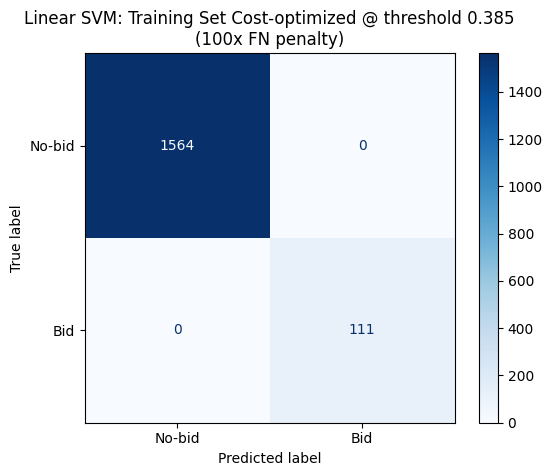


TRAINING DATA THRESHOLD OPTIMIZATION:
Balanced threshold (FN ≈ FP): 0.385 → FN: 0, FP: 0
Cost-optimal threshold: 0.385 → FN: 0, FP: 0
Threshold difference: 0.000
⚠️  Small threshold difference - cost function may need adjustment


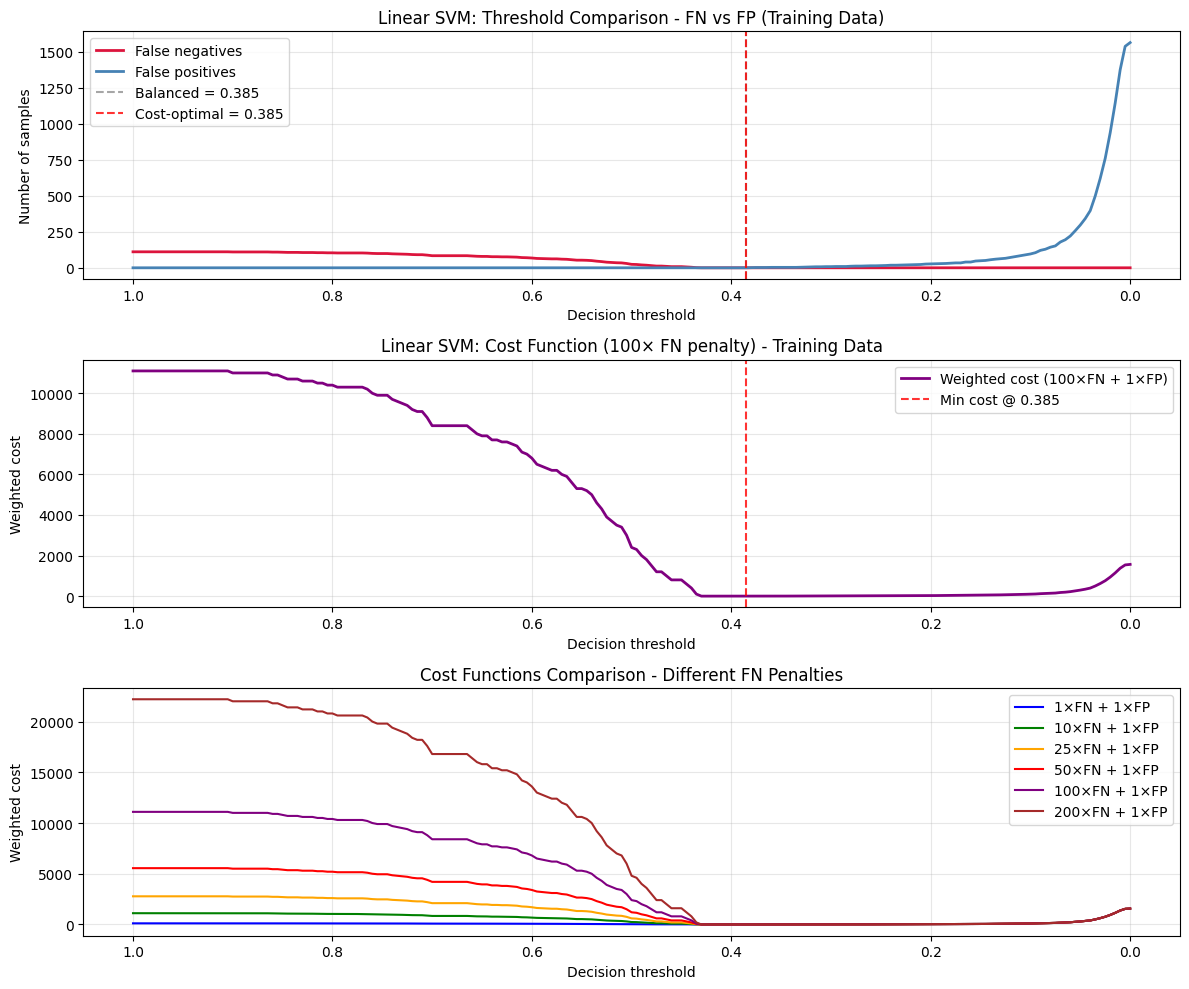

In [45]:
# ------------------------------------------------------------------
# 5.  Apply a COST to false negative vs. false positives (on training data)
# ------------------------------------------------------------------
print("Cost-sensitive threshold optimization (on training data):")
print("=" * 50)

# Let's test different cost ratios to see the impact
cost_ratios = [1, 10, 25, 50, 100, 200]
cost_results = []

for ratio in cost_ratios:
    stats[f"cost_{ratio}x"] = ratio * stats["false_neg"] + 1 * stats["false_pos"]
    best_cost = stats.loc[stats[f"cost_{ratio}x"].idxmin()]
    
    cost_results.append({
        'ratio': ratio,
        'threshold': best_cost["thr"],
        'fn': int(best_cost["false_neg"]),
        'fp': int(best_cost["false_pos"]),
        'cost': int(best_cost[f"cost_{ratio}x"])
    })

# Display the results
print("\nCost Ratio Analysis:")
print("Ratio | Threshold | FN | FP | Total Cost")
print("-" * 45)
for result in cost_results:
    ratio = result['ratio']
    thr = result['threshold']
    fn = result['fn']
    fp = result['fp']
    cost = result['cost']
    print(f"{ratio:4d}x | {thr:9.3f} | {fn:2d} | {fp:2d} | {cost:10d}")

# Let's use a higher cost ratio that shows clear impact
optimal_ratio = 100  # Increase from 25x to 100x
print(f"\nUsing {optimal_ratio}x cost ratio (Missing bid = {optimal_ratio}x more expensive than extra review)")

stats["cost_optimal"] = optimal_ratio * stats["false_neg"] + 1 * stats["false_pos"]
best_cost = stats.loc[stats["cost_optimal"].idxmin()]

thr_cost_optimal = best_cost["thr"]
fn_cost_optimal  = int(best_cost["false_neg"])
fp_cost_optimal  = int(best_cost["false_pos"])
cost_optimal = int(best_cost["cost_optimal"])

print(f"\nOptimal threshold ({optimal_ratio}x FN cost): {thr_cost_optimal:0.3f}")
print(f"→ False-negatives (missed bids) : {fn_cost_optimal}")
print(f"→ False-positives (extra reviews): {fp_cost_optimal}")
print(f"→ Total weighted cost: {cost_optimal}")
print(f"   Total tenders to review       : {best_cost['pred_bid']:.0f}")

# Compare with balanced threshold
print(f"\nComparison:")
print(f"Balanced threshold: {thr_balanced:.3f} → {fn_balanced} FN, {fp_balanced} FP")
print(f"Cost-optimal threshold: {thr_cost_optimal:.3f} → {fn_cost_optimal} FN, {fp_cost_optimal} FP")

if abs(thr_cost_optimal - thr_balanced) < 0.001:
    print("⚠️  WARNING: Cost optimization had minimal impact on threshold!")
    print("   Consider using an even higher cost ratio or examining the probability distribution.")
else:
    print("✅ Cost optimization successfully shifted the threshold!")

# Optional sanity-check – confusion matrix at that threshold on TRAINING data
y_pred_opt = (proba >= thr_cost_optimal).astype(int)
cm = confusion_matrix(y_train, y_pred_opt, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No-bid", "Bid"]
)
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Linear SVM: Training Set Cost-optimized @ threshold {thr_cost_optimal:0.3f}\n({optimal_ratio}x FN penalty)")
plt.show()

# ------------------------------------------------------------------
#  Visualize the cost-sensitive threshold selection (on training data)
# ------------------------------------------------------------------

# 1. find threshold where FN and FP are closest (for comparison)
stats["gap"] = (stats["false_neg"] - stats["false_pos"]).abs()
best_balanced = stats.loc[stats["gap"].idxmin()]
thr_balanced = best_balanced["thr"]
fn_balanced = int(best_balanced["false_neg"])
fp_balanced = int(best_balanced["false_pos"])

# 2. cost-optimal threshold (already calculated above)
thr_cost = thr_cost_optimal
fn_cost = fn_cost_optimal
fp_cost = fp_cost_optimal

print(f"\nTRAINING DATA THRESHOLD OPTIMIZATION:")
print(f"Balanced threshold (FN ≈ FP): {thr_balanced:0.3f} → FN: {fn_balanced}, FP: {fp_balanced}")
print(f"Cost-optimal threshold: {thr_cost:0.3f} → FN: {fn_cost}, FP: {fp_cost}")

# Show the difference in thresholds
threshold_diff = abs(thr_cost - thr_balanced)
print(f"Threshold difference: {threshold_diff:.3f}")

if threshold_diff < 0.01:
    print("⚠️  Small threshold difference - cost function may need adjustment")
else:
    print("✅ Meaningful threshold difference achieved")

# 3. plot the curves with both thresholds annotated
plt.figure(figsize=(12, 10))

# Main plot
plt.subplot(3, 1, 1)
sns.lineplot(data=stats, x="thr", y="false_neg", label="False negatives", color="crimson", linewidth=2)
sns.lineplot(data=stats, x="thr", y="false_pos", label="False positives", color="steelblue", linewidth=2)

plt.axvline(thr_balanced, color="gray", ls="--", alpha=0.7, label=f"Balanced = {thr_balanced:0.3f}")
plt.axvline(thr_cost, color="red", ls="--", alpha=0.8, label=f"Cost-optimal = {thr_cost:0.3f}")

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Number of samples")
plt.title("Linear SVM: Threshold Comparison - FN vs FP (Training Data)")
plt.legend()
plt.grid(True, alpha=0.3)

# Cost plot
plt.subplot(3, 1, 2)
sns.lineplot(data=stats, x="thr", y="cost_optimal", label=f"Weighted cost ({optimal_ratio}×FN + 1×FP)", color="purple", linewidth=2)
plt.axvline(thr_cost, color="red", ls="--", alpha=0.8, label=f"Min cost @ {thr_cost:0.3f}")

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Weighted cost")
plt.title(f"Linear SVM: Cost Function ({optimal_ratio}× FN penalty) - Training Data")
plt.legend()
plt.grid(True, alpha=0.3)

# Cost ratio comparison
plt.subplot(3, 1, 3)
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']
for i, ratio in enumerate(cost_ratios):
    if f"cost_{ratio}x" in stats.columns:
        sns.lineplot(data=stats, x="thr", y=f"cost_{ratio}x", 
                    label=f"{ratio}×FN + 1×FP", color=colors[i], linewidth=1.5)

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Weighted cost")
plt.title("Cost Functions Comparison - Different FN Penalties")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL EVALUATION ON TEST SET

Threshold optimization was done on TRAINING data:
  1. Balanced threshold (FN ≈ FP): 0.385
  2. Cost-optimal threshold (25×FN): 0.385

Evaluating these thresholds on TEST set:

1. BALANCED THRESHOLD (0.385) on test set:
   → False-negatives: 19 (missed bids)
   → False-positives: 2 (extra reviews)
   → Total to review: 11
   → Test recall: 0.321
   → Test precision: 0.818

2. COST-OPTIMAL THRESHOLD (0.385) on test set:
   → False-negatives: 19 (missed bids)
   → False-positives: 2 (extra reviews)
   → Total to review: 11
   → Test recall: 0.321
   → Test precision: 0.818
   → Weighted cost: 477


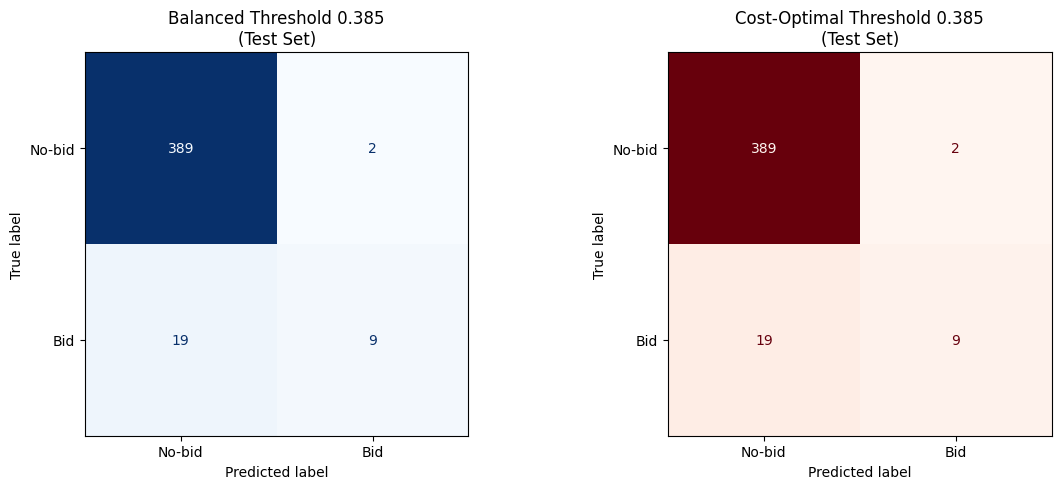

In [46]:
# Final Evaluation: Apply optimized thresholds to TEST set
print("=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

# Get test set probabilities
proba_test = calibrated.predict_proba(X_test)[:, 1]

# Evaluate both optimized thresholds on test set
print(f"\nThreshold optimization was done on TRAINING data:")
print(f"  1. Balanced threshold (FN ≈ FP): {thr_balanced:.3f}")
print(f"  2. Cost-optimal threshold (25×FN): {thr_cost:.3f}")

print(f"\nEvaluating these thresholds on TEST set:")
print(f"=" * 50)

# 1. Balanced threshold performance on test set
y_pred_balanced = (proba_test >= thr_balanced).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_balanced).ravel()

print(f"\n1. BALANCED THRESHOLD ({thr_balanced:.3f}) on test set:")
print(f"   → False-negatives: {fn} (missed bids)")
print(f"   → False-positives: {fp} (extra reviews)")
print(f"   → Total to review: {tp + fp}")
print(f"   → Test recall: {tp/(tp+fn):.3f}")
print(f"   → Test precision: {tp/(tp+fp):.3f}")

# 2. Cost-optimal threshold performance on test set
y_pred_cost = (proba_test >= thr_cost).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_cost).ravel()

print(f"\n2. COST-OPTIMAL THRESHOLD ({thr_cost:.3f}) on test set:")
print(f"   → False-negatives: {fn} (missed bids)")
print(f"   → False-positives: {fp} (extra reviews)")  
print(f"   → Total to review: {tp + fp}")
print(f"   → Test recall: {tp/(tp+fn):.3f}")
print(f"   → Test precision: {tp/(tp+fp):.3f}")
print(f"   → Weighted cost: {25 * fn + fp}")

# Show confusion matrices for both thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Balanced threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_balanced, display_labels=["No-bid", "Bid"], 
    cmap="Blues", ax=ax1, colorbar=False
)
ax1.set_title(f"Balanced Threshold {thr_balanced:.3f}\n(Test Set)")

# Cost-optimal threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cost, display_labels=["No-bid", "Bid"], 
    cmap="Reds", ax=ax2, colorbar=False
)
ax2.set_title(f"Cost-Optimal Threshold {thr_cost:.3f}\n(Test Set)")

plt.tight_layout()
plt.show()


FINAL EVALUATION ON TEST SET
Cost-optimized threshold (from training set): 0.385

Test set evaluation at cost-optimized threshold:
[[389   2]
 [ 19   9]]
              precision    recall  f1-score   support

           0      0.953     0.995     0.974       391
           1      0.818     0.321     0.462        28

    accuracy                          0.950       419
   macro avg      0.886     0.658     0.718       419
weighted avg      0.944     0.950     0.939       419



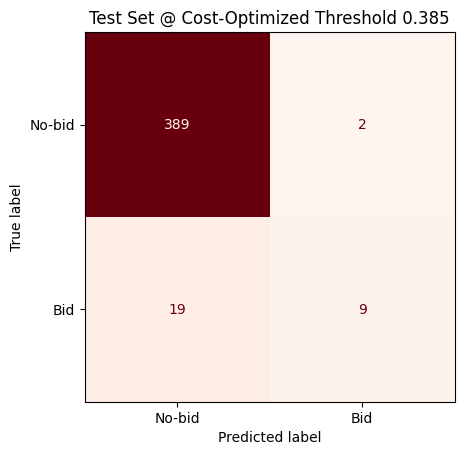

In [49]:
# Final Evaluation: Apply cost-optimized threshold from TRAINING set to TEST set
print("=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

# Get test set probabilities
proba_test = calibrated.predict_proba(X_test)[:, 1]

# Use the cost-optimized threshold found on the training set
y_pred_cost = (proba_test >= thr_cost_optimal).astype(int)

# Report confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

print(f"Cost-optimized threshold (from training set): {thr_cost_optimal:.3f}")
print("\nTest set evaluation at cost-optimized threshold:")
print(confusion_matrix(y_test, y_pred_cost))
print(classification_report(y_test, y_pred_cost, digits=3))

# Optionally, plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cost, display_labels=["No-bid", "Bid"], cmap="Reds", colorbar=False
)
plt.title(f"Test Set @ Cost-Optimized Threshold {thr_cost_optimal:.3f}")
plt.show()

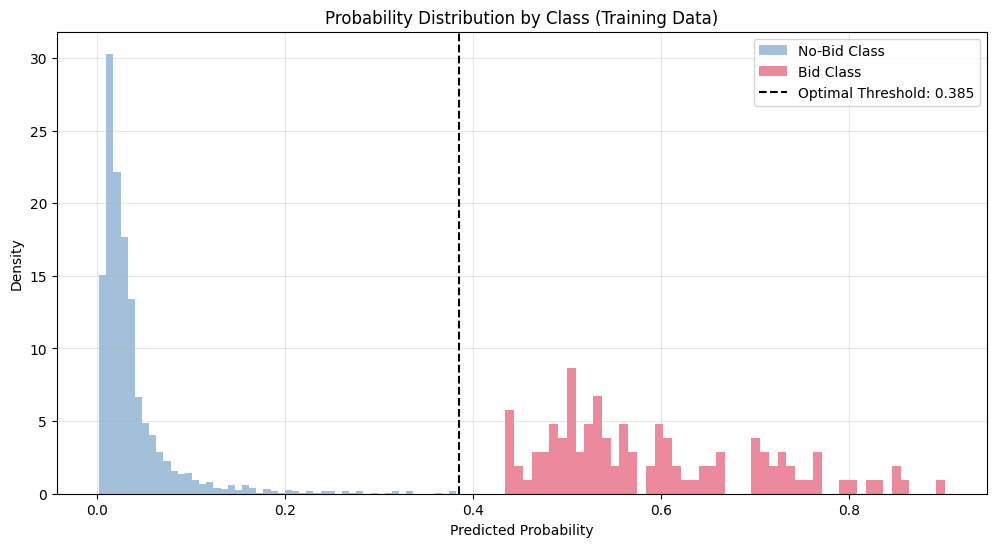

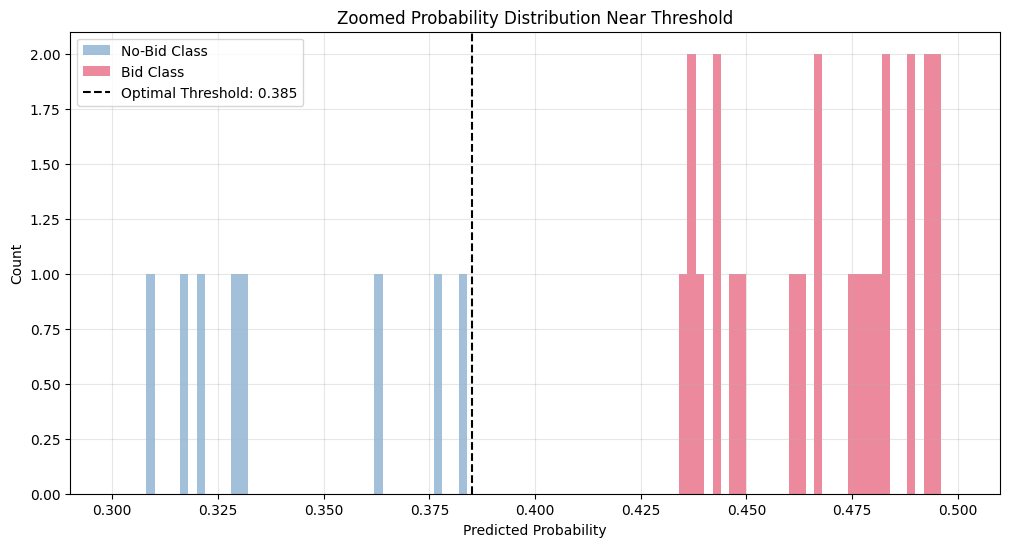

In [50]:
# Add this after cell 7 or 8
plt.figure(figsize=(12, 6))

# Plot probability distributions by class
plt.hist(proba_train[y_train == 0], bins=50, alpha=0.5, density=True, 
         label='No-Bid Class', color='steelblue')
plt.hist(proba_train[y_train == 1], bins=50, alpha=0.5, density=True,
         label='Bid Class', color='crimson')

# Mark the optimal threshold
plt.axvline(thr_opt, color='black', linestyle='--', 
            label=f'Optimal Threshold: {thr_opt:.3f}')

plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Probability Distribution by Class (Training Data)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Add a zoomed-in view of the critical region
plt.figure(figsize=(12, 6))
plt.hist(proba_train[y_train == 0], bins=100, range=(0.3, 0.5), alpha=0.5, 
         label='No-Bid Class', color='steelblue')
plt.hist(proba_train[y_train == 1], bins=100, range=(0.3, 0.5), alpha=0.5, 
         label='Bid Class', color='crimson')
plt.axvline(thr_opt, color='black', linestyle='--', 
            label=f'Optimal Threshold: {thr_opt:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Zoomed Probability Distribution Near Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generating learning curve (this may take a while)...


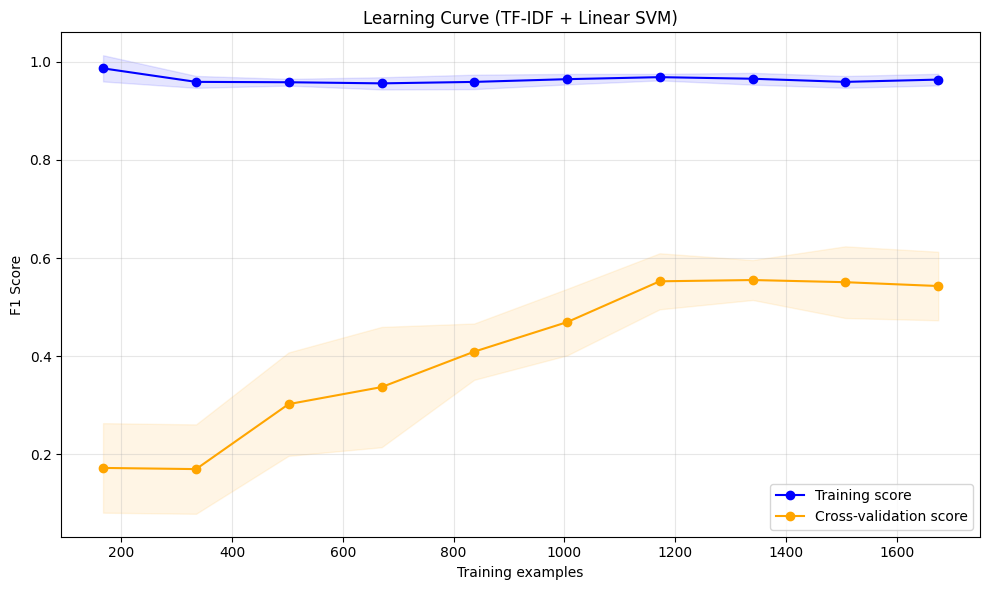

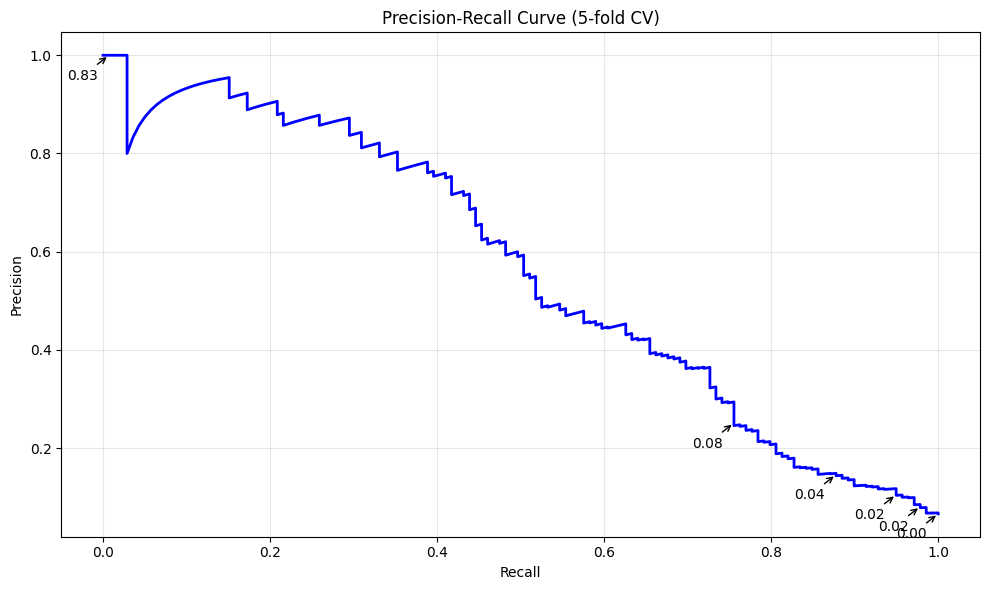

In [51]:
# Add after model definition (after cell 3)
from sklearn.model_selection import learning_curve

print("Generating learning curve (this may take a while)...")

# Define a simpler pipeline for learning curve analysis (without calibration)
# to speed up computation
learning_pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])

# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    learning_pipe, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1",  # Using F1 score since data is imbalanced
    n_jobs=-1,
    random_state=42
)

# Calculate mean and std for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.grid(True, alpha=0.3)

plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, 
    alpha=0.1, color="blue"
)
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, 
    alpha=0.1, color="orange"
)

plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training score")
plt.plot(train_sizes, val_mean, "o-", color="orange", label="Cross-validation score")

plt.title("Learning Curve (TF-IDF + Linear SVM)")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Optional: Add a precision-recall curve as well
from sklearn.metrics import precision_recall_curve

# Use cross-validation to get predictions
cv_proba = cross_val_predict(
    calibrated, X, y, cv=5, method="predict_proba", n_jobs=-1
)[:, 1]

precision, recall, thresholds = precision_recall_curve(y, cv_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, "b-", linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (5-fold CV)")

# Mark a few threshold points
for t, p, r in zip(thresholds[::len(thresholds)//5], precision[::len(precision)//5], recall[::len(recall)//5]):
    plt.annotate(f"{t:.2f}", xy=(r, p), xytext=(r-0.05, p-0.05),
                arrowprops=dict(arrowstyle="->", lw=1))

plt.tight_layout()
plt.show()